# Deep Q Learning

In this exercise we will build a simple deep Q-learning agent from scratch. For this we need to look at the following tasks:
* How do we specify the model?
* How do we calculate an action?
* How do we sample episodes?
* How do we train the model?

We will develop this by implementing a class for the agent. We will use a package called jdc, that will allow us to split the implementation of a class over several cells.

We will be using torch for the implementation of the neural network and the training.

In [1]:
!pip install jdc
import jdc
import numpy as np
import tqdm
import gymnasium as gym

from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
import pyglet
import ipywidgets
from IPython import display

%matplotlib inline


## Example: Cart Pole
We will use an environment from OpenAI for this exercise. The goal is to balance a pole by moving the attached cart to the left or to the right. As the pole should be balanced as long as possible, the reward for each time step is +1. An episode is done when the angle of the pole becomes too large.

The observation space gives some measurements about the pole, for example the angle. However, we actually do not need to know the specific details, as the neural network will just learn using the input.

The actions are to move the cart to the left or to the right.

In [2]:
environment_name = 'CartPole-v1'
env = gym.make(environment_name, render_mode='rgb_array')

print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

print(f'Sample from the observation space: {env.observation_space.sample()}')

Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)
Sample from the observation space: [ 4.21415     0.5104905  -0.40308246 -0.5030688 ]


The environment has a render function that we can use to display the state. The parameter 'render_mode' is used to specify the mode. For standalone applications, we can use 'human' that will open a window. Here we get the image as an array and display it using matplotlib.

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


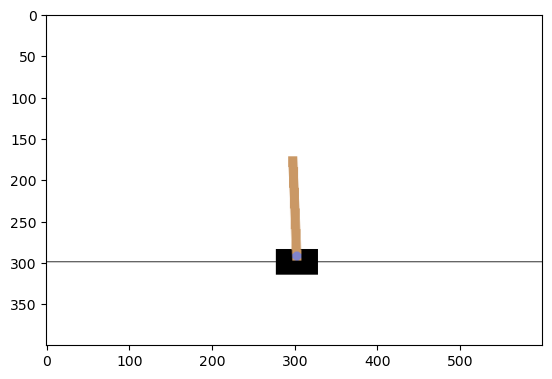

In [3]:
env.reset()
plt.imshow(env.render())
plt.show()

We can also try to render a sequence of images. Depending on your browser the display might not be optimal...


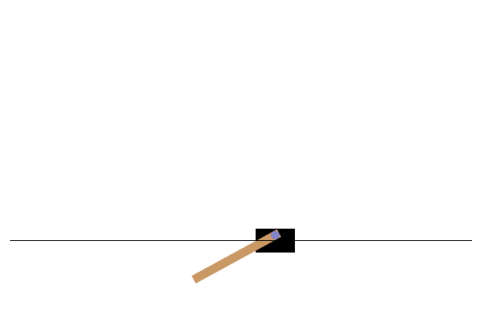

In [4]:
def display_environment(env):
    plt.figure(figsize=(6,4))
    plt.imshow(env.render())
    plt.axis('off') 
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.close()

# Test the function with a few steps
env.reset()
for _ in range(50):
    env.step(env.action_space.sample())  # Take a random action
    display_environment(env)



## Build the model

Our agent will use the class of the neural network (the model) as parameter, so that we can call it using different models. The first task is to write a example class that for the neural network. We will pass the number of observation values and the number of actions values as parameters.

The model must calculate the q function for each state. We will also need to access those values for evaluation.

Build a sequential model using at least two dense layers. 


In [5]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # test if it worked
        x = torch.ones(1, device=device)
        print('Using CUDA device')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        x = torch.ones(1, device=device)
        print('Using MPS device')
    else:
        print('Using CPU')
        device = torch.device('cpu')
    return device

In [6]:
class DQNetwork(nn.Module):
    def __init__(self, n_obs, n_action):
        super(DQNetwork, self).__init__()
        # generate a sequential model in a internal variable (for example self.fc)
        # YOUR CODE HERE
        self.fc = nn.Sequential(
            nn.Linear(n_obs, 32),
            nn.ReLU(),
            nn.Linear(32, n_action)
        )

    def forward(self, x_tensor):
        # forward should just call you model
        # YOUR CODE HERE
        return self.fc(x_tensor)

    def q_values(self, obs_tensor):
        with torch.no_grad():
            q = self.forward(obs_tensor)
        return q

In [7]:
m = DQNetwork(env.observation_space.shape[0], env.action_space.n)
print(m)


obs_sample = env.observation_space.sample()

# models expect a batch of data, so we have to add a dimension and convert it to a tensor
obs_batch = np.expand_dims(obs_sample, axis=0)
obs_batch_tensor = torch.from_numpy(obs_batch).float()
action_values = m.q_values(obs_batch_tensor)
assert action_values.shape == (1,2)



DQNetwork(
  (fc): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)


### Device managment in torch

In order to use the gpu, we have to move our models to the device. We will also set this as
default device, so that any tensors will be initialized on it and we don't have to specify them every time.

In the code, we will use _tensor whenever a torch tensor is used.

In [8]:
device = get_device()
torch.set_default_device(device)

Using CUDA device


## Agent class

Now we are ready to implement the agent class. Check the parameters and their descriptions as they will be used in the implementation and you will have to find suitable hyperparameters for them.


The only thing to fill out is the optimizer and the loss function. 

There are different optimizers available, either standand SGD or Adam would be possible and should be initialized with the learning rate given in the parameters.

What is the loss function that we have to use?


In [9]:
class DQNAgent:
    def __init__(self, 
                 observation_space, 
                 action_space,
                 model_cls,
                 device,
                 gamma: float,
                 epsilon: float, epsilon_decay: float, epsilon_min: float,
                 learning_rate: float, training_frequency: int, target_update_frequency: int,
                 tau : float, use_double_dqn: bool,
                 batch_size: int, memory_size: int):
        """
        Initialise the agent.
        Args:
            observation_space: The observation space of the environment
            action_space: The action space of the environment
            model_cls: the class that implements the model,
            device: the device to run torch on
            gamma: The discount factor
            epsilon: The initial epsilon value for the epsilon-greedy policy
            epsilon_decay: The decay factor for the epsilon value
            epsilon_min: The minimal epsilon value after which it will not be decayed further
            learning_rate: The learning rate for the optimizer
            training_frequency: The frequency (in steps) of training the model
            target_update_frequency: The frequency (in steps) of updating the target model (if not using tau)
            tau: weight of the new model in the target update 
            use_double_dqn: use double q learning
            batch_size: The batch size for training (sampled from the memory)
            memory_size: The size of the memory for storing experiences
        """
        self.observation_space = observation_space
        self.action_space = action_space
    
        # hyperparameters from parameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        self.training_frequency = training_frequency
        self.target_update_frequency = target_update_frequency
    
        self.use_double_dqn = use_double_dqn
        self.tau = tau

        self.nr_training_steps = 0
    
        # internal variables
        self.nr_steps = 0
    
        self.last_action = None
        self.last_obs = None

        self.device = device
    
        # build the models
        # self.model = DQNetwork(observation_space.shape[0], action_space.n)
        # self.target_model = DQNetwork(observation_space.shape[0], action_space.n)
        self.model = model_cls(self.observation_space.shape[0], self.action_space.n)
        self.target_model = model_cls(self.observation_space.shape[0], self.action_space.n)

        self.model = self.model.to(self.device)
        self.target_model = self.target_model.to(self.device)

        
        self.optimizer = None
        self.loss = None 

        # generate the optimizer and loss function in the variables above
        # YOUR CODE HERE
        self.optimizer = optim.Adam(self.model.parameters() ,lr=learning_rate)
        self.loss = nn.MSELoss(reduction='mean')

    def reset(self):
        """
        Reset the agent to the initial state
        """
        self.nr_steps = 0
        self.last_action = None
        self.last_obs = None
        self.nr_training_steps = 0
    

In [10]:
q_agent = DQNAgent(env.observation_space, env.action_space,
                       gamma=0.99,
                       epsilon=0.5,
                       model_cls=DQNetwork,
                       device=device,
                       epsilon_min=0.03,
                       epsilon_decay=0.9,
                       learning_rate=0.0005,
                       training_frequency=1,
                       target_update_frequency=2,
                       tau=0.0,
                       use_double_dqn=False,
                       batch_size=256,
                       memory_size=10000)


### Updating of the target model

It is important in Q-Learning that the model that is trained and the target model used to calculate the target functions are not the same. The target model should stay fixed for a while or change only slowly.

There are different methods to update the model:
- Replace the target model every number of steps
- Interpolate between the policy and the target model

Implement the update to use the replacement when the parameter tau is equal to 0 and the interpolation (using tau) when tau is greater than 0. You should later experiment with both update functions

In [11]:
%%add_to DQNAgent

def update_target_model(self):
        """
        Update the target model with the weights from the current model. There are two possibilities for
        updating:
        - Replace the target model every number of steps
        - Interpolate between the policy and the target model

        In both cases the update_target_model method will be called every self.target_update_frequency 
        number of steps (not training steps). If the update is done by replacement, the value should be
        higher, if the update is done by interpolation it can be lower.
        """
        
        
        policy_net_state_dict = self.model.state_dict()
        target_model_state_dict = self.target_model.state_dict()

        if self.tau > 0.0:
            # YOUR CODE HERE
            for key in policy_net_state_dict:
                target_model_state_dict[key] = policy_net_state_dict[key] * self.tau + target_model_state_dict[key] *(1-self.tau)
            self.target_model.load_state_dict(target_model_state_dict)
        else:
            # YOUR CODE HERE
            self.target_model.load_state_dict(policy_net_state_dict)

In [12]:
q_agent = DQNAgent(env.observation_space, env.action_space,
                       gamma=0.99,
                       epsilon=0.5,
                       model_cls=DQNetwork,
                       device=device,
                       epsilon_min=0.03,
                       epsilon_decay=0.9,
                       learning_rate=0.0005,
                       training_frequency=1,
                       target_update_frequency=2,
                       tau=0.0,
                       use_double_dqn=False,
                       batch_size=256,
                       memory_size=10000)
q_agent.update_target_model()

## Calculating actions

Calculating actions is done with an epsilon greedy policy. However, for evaluation it is often suitable to use the greedy policy instead. So we add a parameter `stochastic`, if it is True then the epsilon-greedy policy is used, if not, the greedy policy is used.


In [13]:
%%add_to DQNAgent

def calculate_action(self, obs_tensor, stochastic: bool = True) -> int:
    """
    Calculate the action for the given observation.
    Args:
        obs: the observation
        stochastic: whether to use a stochastic (epsilon greedy) policy or not
    Returns:
        the action
    """
    if not stochastic or np.random.rand() > self.epsilon:
        # calculate greedy action
        with torch.no_grad():
            action_value = self.model.q_values(obs_tensor)
        return torch.argmax(action_value).numpy(force=True)
    else:
        # calculate random action
        return self.action_space.sample()

In [14]:
agent = DQNAgent(env.observation_space, env.action_space,
                 model_cls=DQNetwork,
                 device=device,
                 gamma=0.99,
                 epsilon=0.9,
                 epsilon_min=0.03,
                 epsilon_decay=0.9999,
                 learning_rate=0.0005,
                 training_frequency=1,
                 target_update_frequency=2,
                 tau=0.005,
                 use_double_dqn=False,
                 batch_size=256,
                 memory_size=10000)
obs_tensor = torch.tensor(env.observation_space.sample())
a = agent.calculate_action(obs_tensor)
assert env.action_space.contains(a)
a = agent.calculate_action(obs_tensor, stochastic=False)
assert env.action_space.contains(a)

## Add the steps

Next we will add the two step functions as in the previous implementations of an agent. The `step_first` method is called after the environment is reset and we do not have any rewards yet.

The `step` method is called for all other steps. In the step method we need to
* Save the current experience (S, A, R, S', done) in the memory.
* Calculate the next action
* Save action and observation for next step
* train the model every couple of steps
* update the target model every couple of steps

You have to fill in the code for the first three items.


In [15]:
%%add_to DQNAgent    
def step_first(self, obs):
    """
    Calculate the action for the first step in the environment after a reset.
    Args:
        obs: The observation from the environment
    Returns:
        the action
    """
    self.last_obs = np.array(obs)
    obs_tensor = torch.tensor(self.last_obs, dtype=torch.float32)
    self.last_action = self.calculate_action(obs_tensor)
    
    return self.last_action

def step(self, obs, reward: float, done: bool):

    # Konvertiere die Beobachtung in ein NumPy-Array und dann in einen Tensor
    obs = np.array(obs)  # Um sicherzustellen, dass es ein Array ist
    obs_tensor = torch.tensor(obs, dtype=torch.float32)  # Umwandlung in Tensor
    
    # Füge die letzte Erfahrung zum Replay-Speicher hinzu
    self.memory.append((self.last_obs, self.last_action, reward, obs, done))

    # Berechne die nächste Aktion
    self.last_action = self.calculate_action(obs_tensor)
    self.last_obs = obs  # Aktualisiere die letzte Beobachtung
    self.nr_steps += 1

    if self.nr_steps % self.training_frequency == 0:
        self.train_model()

    if self.nr_steps % self.target_update_frequency == 0:
        self.update_target_model()

    return self.last_action

In [16]:
agent = DQNAgent(env.observation_space, env.action_space,
                 model_cls=DQNetwork,
                 device=device,
                 gamma=0.99,
                 epsilon=0.9,
                 epsilon_min=0.03,
                 epsilon_decay=0.9999,
                 learning_rate=0.0005,
                 training_frequency=1,
                 target_update_frequency=2,
                 tau=0.005,
                 use_double_dqn=False,
                 batch_size=256,
                 memory_size=10000)
a = agent.step_first(env.observation_space.sample())

## Train the model function

The last thing to do is now to train the model. For this we have to 
* Sample from the memory to get a batch of observations, actions, rewards, next observations and dones
* Calculate a better estimate for the q values of the current observation using q-learning
* Fit the model to the updated values using gradient descend on the loss
* Decay the epsilon value

In torch, the gradient descend step has to be calculated in the code. Todo this:
* Calculate the model output
* Calculate the loss function
* Clear the gradient (using self.optimizer.zero_grad())
* Calculate a backwards step (resulting in the gradient)
* Apply the step in the optimizer

Note that between calculating the model, and calculating the loss function, you will have to calculate the target function (using the target_model), as no gradients are required on the target model, this code should be within a `with torch.no_grad()` block.


In [17]:
%%add_to DQNAgent

def train_model(self):
    # not enough samples yet
    if len(self.memory) < self.batch_size:
        return

    self.nr_training_steps += 1

    # Sample random minibatch from memory
    indices = np.random.choice(len(self.memory), size=self.batch_size, replace=False)

    # Unpack batch
    obs = np.array([self.memory[i][0] for i in indices])
    actions = np.array([self.memory[i][1] for i in indices])
    rewards = np.array([self.memory[i][2] for i in indices])
    obs_next = np.array([self.memory[i][3] for i in indices])
    dones = np.array([self.memory[i][4] for i in indices])

    # Convert to torch tensors
    obs_tensor = torch.tensor(obs, dtype=torch.float32).to(self.device)
    actions_tensor = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
    rewards_tensor = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
    obs_next_tensor = torch.tensor(obs_next, dtype=torch.float32).to(self.device)
    dones_tensor = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

    # Calculate Q-values for the current observation using the model
    q_values = self.model(obs_tensor).gather(dim=1, index=actions_tensor)

    # Calculate the target Q-values using the target model (without gradients)
    with torch.no_grad():
        next_q_values = self.target_model(obs_next_tensor).max(1, keepdim=True)[0]
        target_q_values = rewards_tensor + (1 - dones_tensor) * self.gamma * next_q_values

    # Compute the loss between current Q-values and target Q-values
    loss = self.loss(q_values, target_q_values)

    # Backpropagation to compute gradients
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # Decay epsilon
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

In [18]:
# Test with a small version of the agent
agent = DQNAgent(env.observation_space, env.action_space,
                 model_cls=DQNetwork,
                 device=device,
                       gamma=0.99,
                       epsilon=0.5,
                       epsilon_min=0.03,
                       epsilon_decay=0.9,
                       learning_rate=0.0005,
                       training_frequency=1,
                       target_update_frequency=20,
                       tau=0.00,
                       use_double_dqn=False,
                       batch_size=4,
                       memory_size=16)
obs, info = env.reset()
action = agent.step_first(obs)

for i in range(20):
    obs, reward, done, truncated, info = env.step(action)
    action = agent.step(obs, reward, done)

    if done or truncated:
        obs, info = env.reset()
        action = agent.step_first(obs)
assert agent.nr_training_steps > 4
    

Congratulations! You have implemented a full DQN Agent.

## Complete agent for training and evaluation.

We will add some additional methods to the agent in order to train and evaluate it more easily.

In [19]:
%%add_to DQNAgent

def train(self, env: gym.Env, nr_episodes_to_train: int,  eval_env: gym.Env, eval_frequency: int):
    """
    Train the agent on the given environment for the given number of steps.
    Args:
        env: The environment on which to train the agent
        nr_episodes_to_train: the number of episodes to train
        eval_env: Environment for evaluation
        eval_frequency: Frequency of evaluation of the trained agent
    """
    nr_episodes = 0
    while True:
        obs, _ = env.reset()
        a = self.step_first(obs)
        done = False
        truncated = False
        while not done and not truncated:
            obs, reward, done, truncated, _ = env.step(a)
            done = done or truncated
            a = self.step(obs, reward, done)

        nr_episodes += 1
        if nr_episodes % eval_frequency == 0:
            rewards = self.evaluate(eval_env, 10)
            print(f'Evaluation: episode {nr_episodes}, epsilon: {self.epsilon} mean reward: {np.mean(rewards)}')

        if nr_episodes >= nr_episodes_to_train:
            return

def evaluate(self, env: gym.Env, nr_episodes: int):
    """
    Evaluate the agent on the given environment for the given number of episodes.
    Args:
        env: the environment on which to evaluate the agent
        nr_episodes: the number of episodes to evaluate
    Returns:
        the rewards for the episodes
    """
    rewards = []
    for e in range(nr_episodes):
        obs, _ = env.reset()
        obs_tensor = torch.from_numpy(obs).to(self.device)
        a = self.calculate_action(obs_tensor, stochastic=False)
        done = False
        truncated = False
        episode_reward = 0
        # some environments do not support truncated episodes, so we additionally check for a maximal number of steps
        while not done and not truncated:
            obs, reward, done, truncated, _ = env.step(a)
            obs_tensor = torch.from_numpy(obs).to(self.device)
            a = self.calculate_action(obs_tensor, stochastic=False)
            episode_reward += reward
        rewards.append(episode_reward)
    return rewards
            

## Example Training

Here is an example with some hyperparameters and a short training time (that will not be enough to actually train the full agent). You can adjust the parameters and see if you get good results. But for handing in the exercise, put it back to a short training :-). 

In [20]:
env_train = gym.make(environment_name)
env_eval = gym.make(environment_name, render_mode='rgb_array')

 # Hyperparameters will be quite important here.
q_agent = DQNAgent(env_train.observation_space, env_train.action_space,
                   model_cls=DQNetwork,
                   device=device,
                   gamma=0.99,
                   epsilon=0.5,
                   epsilon_min=0.03,
                   epsilon_decay=0.999,
                   learning_rate=0.0005,
                   training_frequency=1,
                   target_update_frequency=2,
                   tau=0.01,
                   use_double_dqn=False,
                   batch_size=256,
                   memory_size=10000)

# the parameters are not optimal, but should already give a result
q_agent.train(env_train, nr_episodes_to_train=400, eval_env=env_eval, eval_frequency=10)


Evaluation: episode 10, epsilon: 0.4483407572091659 mean reward: 46.6
Evaluation: episode 20, epsilon: 0.3334208358186289 mean reward: 9.9
Evaluation: episode 30, epsilon: 0.2989723000004739 mean reward: 9.4
Evaluation: episode 40, epsilon: 0.2686199059255016 mean reward: 9.6
Evaluation: episode 50, epsilon: 0.24231677478799676 mean reward: 9.5
Evaluation: episode 60, epsilon: 0.21858923351697282 mean reward: 8.9
Evaluation: episode 70, epsilon: 0.19561311110057522 mean reward: 9.7
Evaluation: episode 80, epsilon: 0.1612639109059692 mean reward: 45.4
Evaluation: episode 90, epsilon: 0.10188172361156822 mean reward: 60.6
Evaluation: episode 100, epsilon: 0.043527254602211976 mean reward: 107.5
Evaluation: episode 110, epsilon: 0.029970113248546433 mean reward: 382.7
Evaluation: episode 120, epsilon: 0.029970113248546433 mean reward: 340.1
Evaluation: episode 130, epsilon: 0.029970113248546433 mean reward: 432.1
Evaluation: episode 140, epsilon: 0.029970113248546433 mean reward: 323.7
Ev

In [21]:
q_agent.evaluate(env_eval, 5)

[500.0, 500.0, 500.0, 500.0, 500.0]

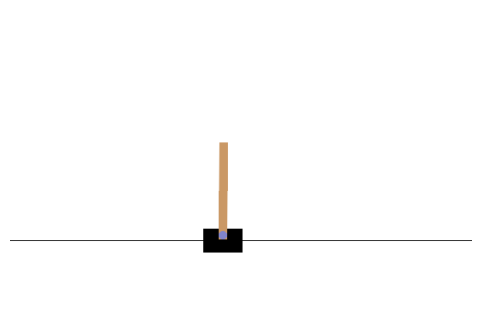

In [29]:
# Test the function with a few steps
env = gym.make(environment_name, render_mode='rgb_array')
obs, _ = env.reset()
obs_tensor = torch.from_numpy(obs).to(device)
for _ in range(200):
    action = q_agent.calculate_action(obs_tensor, stochastic=False)
    obs, _, done, _, _ = env.step(action)  # Take a random action
    obs_tensor = torch.from_numpy(obs).to(device)
    display_environment(env)
    if done:
        break

# Bonus Exercise

Can you try training for another example, like the mountain car from the lecture?

In [26]:
other_env = 'MountainCar-v0'

env_train = gym.make(other_env)
env_eval = gym.make(other_env, render_mode='rgb_array')

print(f'Observation space: {env_eval.observation_space}')
print(f'Action space: {env_eval.action_space}')


Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)


In [27]:
# Test the function with a few steps
env = gym.make(other_env, render_mode='rgb_array')
obs, _ = env.reset()
obs_tensor = torch.from_numpy(obs).to(device)
for _ in range(200):
    action = q_agent.calculate_action(obs_tensor, stochastic=False)
    obs, _, done, _, _ = env.step(action)  # Take a random action
    obs_tensor = torch.from_numpy(obs).to(device)
    display_environment(env)
    if done:
        break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 4x32)